This notebook shows the an example of the implementation of a mechanical degradation model accounting for the Loss of Active Material (LAM) according to [1,2]. The results are compared with those of PyBaMM, showing good agreement between both implementations.

1. X. Zhang, W. Shyy, and A. M. Sastry, “Numerical Simulation of Intercalation-Induced Stress in Li-Ion Battery Electrode Particles,” J. Electrochem. Soc., vol. 154, no. 10, p. A910, Jul. 2007, doi: 10.1149/1.2759840\
2. S. E. J. O’Kane et al., “Lithium-ion battery degradation: how to model it,” Phys. Chem. Chem. Phys., vol. 24, no. 13, pp. 7909–7922, Mar. 2022, doi: 10.1039/D2CP00417H


In [16]:
import os, json
import numpy as np
from cideMOD import (
    CellParser,
    SolverCrashed,
    init_results_folder,
    ModelOptions,
    CSI
)

### Simulation settings
The LAM model is activated by setting the option `solve_LAM` to `True` in `ModelOptions`. For this case we load the json file with the parameters to a dictionary so that in can be later modified in the code.

In [17]:
overwrite = False
case = "Ai_2020"
data_path = f"../../data/data_{case}/"
params = "params_LAM.json"

with open(os.path.join(data_path,params), "r+") as jsonFile:
    dataCell = json.load(jsonFile)
    jsonFile.close()

model_options = ModelOptions(mode='P2D', clean_on_exit=False, solve_LAM=True, particle_order = 5)

### Test plan
Input the test plan, some of the variables will be changed later according to the C-rates

In [18]:
cycle_current = 2.28/34 # [A]
min_step = 12
cycling = {
            "name": "Discharge Cycle",
            "type": "Cycle",
            "count": 2,
            "steps": [
                {
                    "name": "Discharge",
                    "type": "Current", 
                    "value": -cycle_current, 
                    "unit": "A", 
                    "t_max": {"value": 2, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 10,
                    "adaptive": False,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 3,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Pause",
                    "type": "Rest",
                    "t_max": {"value": 600, "unit": "s"},
                    "store_delay": -1,
                    "min_step": 10,
                    "adaptive": False
                },
                {
                    "name": "Charge-CC",
                    "type": "Current", 
                    "value": cycle_current, 
                    "unit": "A", 
                    "t_max": {"value": 2, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 10,
                    "adaptive": False,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 4.2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Charge-CV",
                    "type": "Voltage",
                    "value": 4.199,
                    "unit": "V",
                    "t_max": {"value": 600, "unit": "s"},
                    "store_delay": -1,
                    "min_step": 10,
                    "adaptive": False,
                    "events": [{
                        "type": "Current",
                        "value": 0.02,
                        "unit": "C",  
                        "atol": 1e-4, 
                        "rtol": 1e-3,
                        "goto": "Next" 
                    }]
                },
                {
                    "name": "Pause",
                    "type": "Rest",
                    "t_max": {"value": 60, "unit": "s"},
                    "store_delay": -1,
                    "min_step": 10,
                    "adaptive": False
                },
            ]}
            
cycling_test_plan = {
    'initial_state': {
        'SOC': 1,
        'exterior_temperature': 298
    },
    'steps': [cycling]
    }

### Run simulations

In [ ]:
crates = [1,2,3]

p2D_data={"time": [], "voltage": [], "eps_s_a0_avg":[], "eps_s_c0_avg":[], "sigma_h_a0_avg":[], "sigma_h_c0_avg":[]}

dataCell["positiveElectrode"]["LAM"]["beta"]["value"]=1e-4/3600
dataCell["negativeElectrode"]["LAM"]["beta"]["value"]=1e-4/3600
for crate in crates:
    cycling["steps"][0]["value"] = -crate*cycle_current
    cycling["steps"][2]["value"] = crate*cycle_current
    for step in cycling["steps"]:
        step["min_step"] = min_step/crate

    cycling_test_plan["steps"] = [cycling]

    print("#"*40)
    print(f"Running {crate}C")
    print("#"*40)

    csi = CSI(dataCell, model_options, data_path=data_path, name=f'{case}_LAM_{crate}C', overwrite=overwrite)
    csi.read_test_plan(cycling_test_plan)
    csi.run_test_plan()

    # Store variables for plotting
    for var in p2D_data:
        p2D_data[var].append(np.array(csi.problem.WH.get_global_variable(var), dtype = float))


# Results from cideMOD at 1C

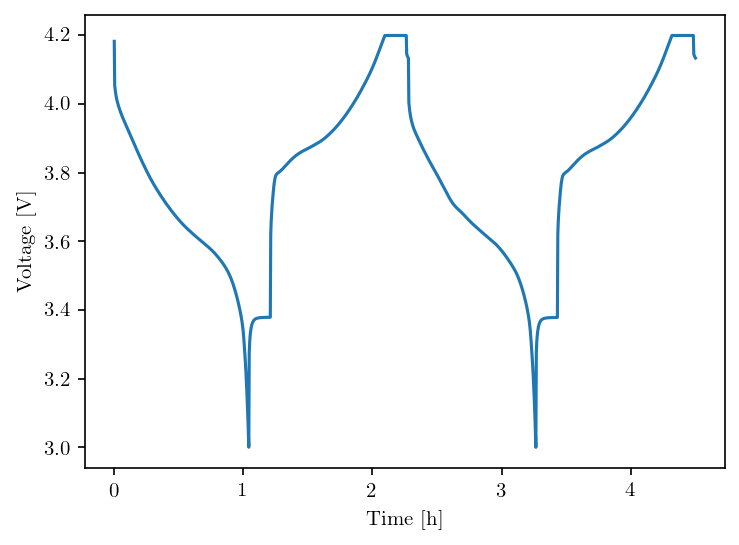

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Get Young modulus
E_a = csi.problem.cell.negative_electrode.active_materials[0].young
E_c = csi.problem.cell.positive_electrode.active_materials[0].young

# Plot voltage vs time
fig1, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=150)
ax1.plot(p2D_data["time"][0]/3600, p2D_data["voltage"][0], "-", label='voltage')
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Voltage [V]")
plt.show()

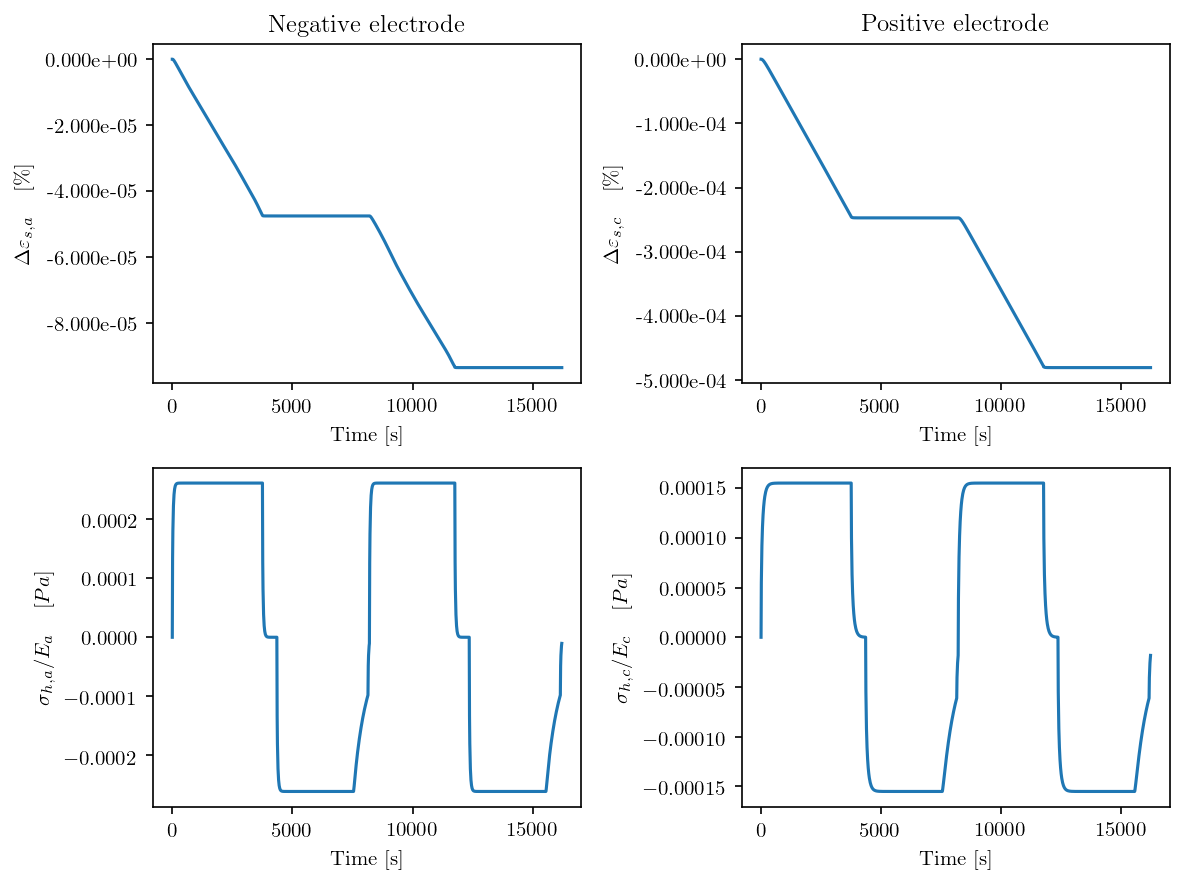

In [ ]:
# Plot eps_s_a0 vs time
fig2, axs = plt.subplots(2, 2, figsize=(8, 6), dpi=150)
axs[0,0].plot(p2D_data["time"][0], p2D_data["eps_s_a0_avg"][0]-p2D_data["eps_s_a0_avg"][0][0], "-", label='eps_s_a0')
axs[0,0].set_title("Negative electrode")
axs[0,0].set_xlabel("Time [s]")
axs[0,0].set_ylabel(r"$\Delta\varepsilon_{s,a} \quad \left[\%\right]$")
axs[0,0].yaxis.set_major_formatter(FormatStrFormatter('%.3e'))

# Plot eps_s_c0 vs time
axs[0,1].plot(p2D_data["time"][0], p2D_data["eps_s_c0_avg"][0]-p2D_data["eps_s_c0_avg"][0][0], "-", label='eps_s_c0')
axs[0,1].set_title("Positive electrode")
axs[0,1].set_xlabel("Time [s]")
axs[0,1].set_ylabel(r"$\Delta\varepsilon_{s,c} \quad \left[\%\right]$")
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.3e'))

# Plot sigma_h_a0 vs time
axs[1,0].plot(p2D_data["time"][0], p2D_data["sigma_h_a0_avg"][0]/E_a, "-", label='sigma_h_a0')
axs[1,0].set_xlabel("Time [s]")
axs[1,0].set_ylabel(r"$\sigma_{h,a}/E_a \quad \left[Pa\right]$")

# Plot sigma_h_c0 vs time
axs[1,1].plot(p2D_data["time"][0], p2D_data["sigma_h_c0_avg"][0]/E_c, "-", label='sigma_h_c0')
axs[1,1].set_xlabel("Time [s]")
axs[1,1].set_ylabel(r"$\sigma_{h,c}/E_c \quad \left[Pa\right]$")
plt.tight_layout()
plt.show()

# Comparison cideMOD with PyBaMM
Compare the results obtained with cideMOD with those in the same conditions.

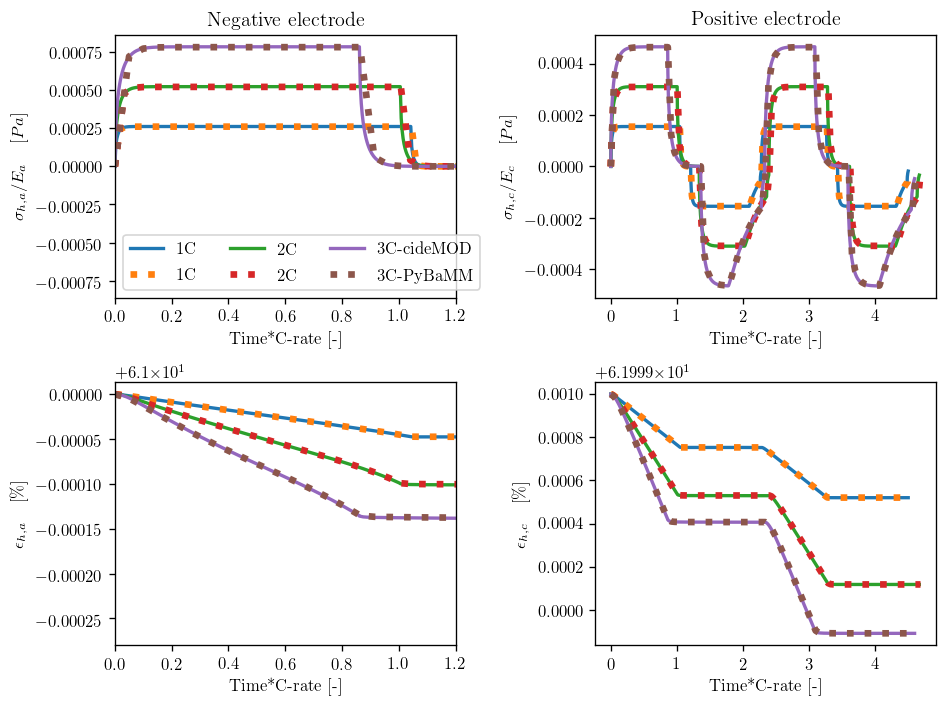

In [ ]:
data_pybamm = os.path.join(data_path,"data_pybamm_LAM/")


fig3, axs = plt.subplots(2, 2, figsize=(8, 6), dpi=120)

for ii, crate in enumerate(crates):

    pybamm_stress=np.genfromtxt(os.path.join(data_pybamm,f"stress_PyBaMM_{crate}C.txt"), delimiter=',')
    pybamm_ep=np.genfromtxt(os.path.join(data_pybamm,f"AM_fraction_PyBaMM_{crate}C.txt"), delimiter=',')

    # Plot sigma_h_a0 vs time
    axs[0,0].plot(p2D_data["time"][ii]/3600*crate, p2D_data["sigma_h_a0_avg"][ii]/E_a, "-", linewidth = 2, label='sigma_h_a0')
    axs[0,0].plot(pybamm_stress[:,0]*crate, pybamm_stress[:,1], ":", linewidth = 4, label='sigma_h_a0_PyBaMM')

    # Plot sigma_h_c0 vs time
    axs[0,1].plot(p2D_data["time"][ii]/3600*crate, p2D_data["sigma_h_c0_avg"][ii]/E_c, "-", linewidth = 2, label='sigma_h_c0')
    axs[0,1].plot(pybamm_stress[:,0]*crate, pybamm_stress[:,2], ":", linewidth = 4, label='sigma_h_c0_PyBaMM')

    # Plot epsilon_a0 vs time
    axs[1,0].plot(p2D_data["time"][ii]/3600*crate, p2D_data["eps_s_a0_avg"][ii], "-", linewidth = 2, label='eps_s_a0')
    axs[1,0].plot(pybamm_ep[:,0]*crate, pybamm_ep[:,1]*100, ":", linewidth = 4, label='eps_s_a0_PyBaMM')

    # Plot epsilon_c0 vs time
    axs[1,1].plot(p2D_data["time"][ii]/3600*crate, p2D_data["eps_s_c0_avg"][ii], "-", linewidth = 2, label='eps_s_c0')
    axs[1,1].plot(pybamm_ep[:,0]*crate, pybamm_ep[:,2]*100, ":", linewidth = 4, label='eps_s_c0_PyBaMM')

axs[0,0].set_xlabel("Time*C-rate [-]")
axs[0,0].set_ylabel(r"$\sigma_{h,a}/E_a \quad \left[Pa\right]$")
axs[0,0].set_title("Negative electrode")
axs[0,0].legend(['1C','1C','2C','2C','3C-cideMOD','3C-PyBaMM'],loc="lower left",ncol=3)
axs[0,0].set_xlim([0,1.2])
axs[0,1].set_xlabel("Time*C-rate [-]")
axs[0,1].set_ylabel(r"$\sigma_{h,c}/E_c \quad \left[Pa\right]$")
axs[0,1].set_title("Positive electrode") 
axs[1,0].set_xlabel("Time*C-rate [-]")
axs[1,0].set_ylabel(r"$\epsilon_{s,a} \quad \left[\%\right]$")
axs[1,0].set_xlim([0,1.2])
axs[1,1].set_xlabel("Time*C-rate [-]")
axs[1,1].set_ylabel(r"$\epsilon_{s,c} \quad \left[\%\right]$")

plt.tight_layout()
plt.show()

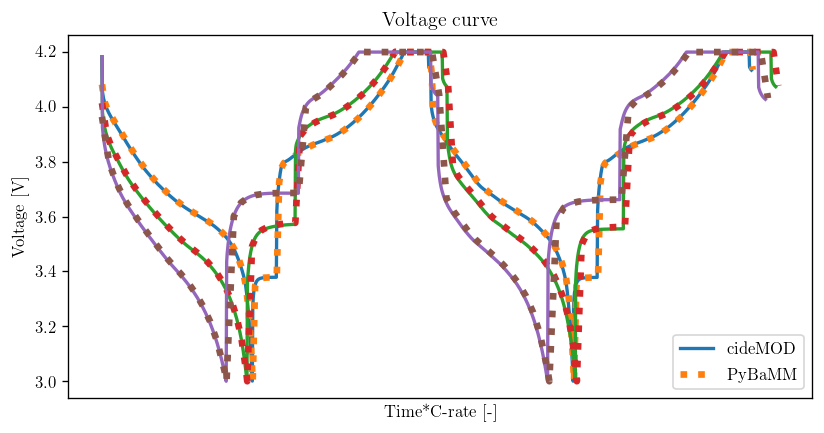

In [ ]:
# Plot Voltage vs Time
fig3, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=120)

for ii, crate in enumerate(crates):
    axs.plot(p2D_data["time"][ii]/3600*crate, p2D_data["voltage"][ii], "-", linewidth = 2, label='cideMOD')
    pybamm_IV=np.genfromtxt(os.path.join(data_pybamm,f"voltage_PyBaMM_{crate}C.txt"), delimiter=',')
    axs.plot(pybamm_IV[:,0]*crate, pybamm_IV[:,1], ":", linewidth = 4, label='PyBaMM')

axs.set_title("Voltage curve")
axs.set_xlabel("Time*C-rate [-]")
axs.set_ylabel("Voltage [V]")
axs.set_xticks([])
# axs.set_xlim([0,4000])
axs.legend(['cideMOD','PyBaMM'],loc="lower right")
plt.show()